In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import argparse
import sys
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import influence
from mnist_convnet import deepnn, linear_model, two_layer_model
from utils import corrupt_mnist
import copy
from IPython.display import clear_output

np.random.seed(1)

FLAGS = None

# Import data
mnist = corrupt_mnist(input_data.read_data_sets("mnist_data", one_hot=True), 0.0)

# Create the model
with tf.name_scope("net"):
    input_ph = tf.placeholder(tf.float32, [None, 784])
    y, weights = deepnn(input_ph)
    #y, weights = linear_model(input_ph)
    #y, weights = two_layer_model(input_ph)

# Define loss and optimizer
with tf.name_scope("loss"):
    y_ = tf.placeholder(tf.float32, [None, 10], name="y_target")
    batch_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    regularization = tf.reduce_sum( [tf.nn.l2_loss(w) for w in weights])
    cross_entropy = tf.reduce_sum(batch_loss) + regularization * 0.001

lr = tf.Variable(0.1)
opt = tf.train.AdamOptimizer(lr)
grads_and_vars = opt.compute_gradients(cross_entropy)
train_step = opt.apply_gradients(grads_and_vars)

# Test trained model
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
sess = tf.InteractiveSession()

tf.global_variables_initializer().run()

gs = [g for g,v in grads_and_vars if g is not None]

#def train(n, mnist=mnist, learning_rate=0.1e-4):
#    sess.run(tf.assign(lr, learning_rate))
#    for _ in range(n):
#        batch_xs, batch_ys = mnist.train.next_batch(64)
#        sess.run(train_step, feed_dict={input_ph: batch_xs, y_: batch_ys})
        
def test():
    test_acc, test_loss = sess.run([accuracy, cross_entropy], feed_dict={input_ph: mnist.test.images,
                                  y_: mnist.test.labels})
    train_acc, train_loss = sess.run([accuracy, cross_entropy], feed_dict=train_feed_dic)
    print("test acc", test_acc)
    print("test loss", test_loss)
    print("train acc", train_acc)
    print("train loss", train_loss) 
    print("---")
    
def testset_loss():
    return sess.run(cross_entropy, feed_dict={input_ph: mnist.test.images, y_: mnist.test.labels})

def train(n, trainset, learning_rate=0.1e-4):
    sess.run(tf.assign(lr, learning_rate))
    for _ in range(n):
        batch_xs, batch_ys = trainset.next_batch(500)
        sess.run(train_step, feed_dict={input_ph: batch_xs, y_: batch_ys})
        
# return a new dataset 
def mnist_i(i):
    new_mnist = copy.deepcopy(mnist)
    new_len = new_mnist.train.images.shape[0] -1
    new_images_shape = [new_len] + list(new_mnist.train.images.shape[1:])
    new_labels_shape = [new_len] + list(new_mnist.train.labels.shape[1:])
    new_mnist.train.images.resize(new_images_shape)
    new_mnist.train.labels.resize(new_labels_shape)
    new_mnist.train.images[:] = np.delete(mnist.train.images, i, axis=0)
    new_mnist.train.labels[:] = np.delete(mnist.train.labels, i, axis=0)
    return new_mnist

# return a new dataset 
def mnist_i2(i):
    return (np.delete(mnist.train.images, i, axis=0), np.delete(mnist.train.labels, i, axis=0))

class Dataset:
    def __init__(self, data):
        self.images = data[0]
        self.labels = data[1]
        self.a = 0 
        self.b = None 
        
    def next_batch(self, batch_size):
        if self.b == None or self.b == len(self.labels):
            self.a = 0
            self.b = batch_size
        else:
            self.a = self.b
            self.b = min(self.a + batch_size, len(self.labels) )
            
        return (self.images[self.a:self.b], self.labels[self.a:self.b])
    
def report():
    acc, gs_np, loss = sess.run([accuracy, gs, cross_entropy], feed_dict=train_feed_dic)
    print("train:")
    print("  grad norm",influence.lnorm(gs_np)/len(train_feed_dic[y_]))
    print("  loss", loss/len(train_feed_dic[y_]))
    print("  accuracy", acc)
    acc, gs_np, loss = sess.run([accuracy, gs, cross_entropy], feed_dict=test_feed_dic)
    print("test:")
    print("  grad norm",influence.lnorm(gs_np)/len(test_feed_dic[y_]))
    print("  loss", loss/len(test_feed_dic[y_]))
    print("  accuracy", acc)

summary_writter = tf.summary.FileWriter("./Hvp_summaries", sess.graph)

testset = (mnist.test.images, mnist.test.labels)
trainset = (mnist.train.images, mnist.train.labels)
#trainset = (mnist.train.images[0:10000], mnist.train.labels[0:10000])

test_feed_dic = {input_ph: mnist.test.images, y_: mnist.test.labels}

batch_xs, batch_ys = mnist.train.next_batch(mnist.test.images.shape[0])
train_feed_dic = {input_ph:batch_xs, y_:batch_ys}

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [ ]:
checkpoint_file = "/home/cgel/deep_quad/checkpoints/convnet.ckpt"

In [3]:
# for big convnets
report()
for i in range(5):
    print(" --- ", i, " --- ")    
    train(2000, mnist.train)
    report()
print("XXXX")
for i in range(5):
    print(" --- ", i, " --- ")
    train(2000, mnist.train, 1e-5)
    report()
print("XXXX")
for i in range(5):
    print(" --- ", i, " --- ")
    train(2000, mnist.train, 1e-6)
    report()
print("XXXX")
for i in range(5):
    print(" --- ", i, " --- ")
    train(2000, mnist.train, 1e-7)
    report()
print("Done")
print("Saving...")
saver.save(sess, checkpoint_file)

train:
  grad norm 10.1759723585
  loss 3.2112140625
  accuracy 0.0901
test:
  grad norm 10.3564189977
  loss 3.20676796875
  accuracy 0.0917
train:
  grad norm 0.27572884189
  loss 0.152076098633
  accuracy 0.9589
test:
  grad norm 0.306558544423
  loss 0.161941589355
  accuracy 0.9526
train:
  grad norm 0.192949988869
  loss 0.0771456787109
  accuracy 0.9818
test:
  grad norm 0.253568856553
  loss 0.109706750488
  accuracy 0.9658
train:
  grad norm 0.144495965171
  loss 0.0434551574707
  accuracy 0.9914
test:
  grad norm 0.243558528398
  loss 0.0878119140625
  accuracy 0.9723
train:
  grad norm 0.105768438724
  loss 0.0247214736938
  accuracy 0.9969
test:
  grad norm 0.210606029485
  loss 0.0759645202637
  accuracy 0.975
train:
  grad norm 0.0689952279067
  loss 0.0137476272583
  accuracy 0.9994
test:
  grad norm 0.208871371474
  loss 0.0690491210937
  accuracy 0.9773
XXXX
train:
  grad norm 0.0386478232925
  loss 0.00762276000977
  accuracy 1.0
test:
  grad norm 0.239533138488
  los

In [2]:
saver.restore(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")

In [ ]:
# for small models
#report()
#for i in range(2):
#    print(" --- ", i, " --- ")
    train(2000, mnist.train, 1e-4)
    report()
print("XXXX")
print("Done")

In [9]:
scale = float(len(trainset[0])) * 10
inf = influence.Influence(cross_entropy/scale, input_ph, y_, testset, trainset, cg_iters = 30, dampening=0.0001, vervose=3)

Error: 0.158550940676
- iter: 0
Error: 0.53121552238
dad: 1.05565542146e-05
alpha: 2381.30741599
beta: 11.2254534224
Ad scaling: 0.00146830752055
d norm: 1.85739065956
- iter: 1
Error: 0.436375497543
dad: 0.000732408770821
alpha: 385.290235411
beta: 0.674806351049
Ad scaling: 0.000960642531836
d norm: 1.32717087079
- iter: 2
Error: 0.236563256166
dad: 0.00078577500761
alpha: 242.338541038
beta: 0.293882550133
Ad scaling: 0.00154332877088
d norm: 0.456165984995
- iter: 3
Error: 0.134438829137
dad: 0.000267783315305
alpha: 208.98301292
beta: 0.322964718976
Ad scaling: 0.00285422039107
d norm: 0.199445764999
- iter: 4
Error: 0.0903037795676
dad: 7.0002915215e-05
alpha: 258.186455915
beta: 0.451192718079
Ad scaling: 0.00314506096226
d norm: 0.127486057968
- iter: 5
Error: 0.0510337019456
dad: 3.36315651804e-05
alpha: 242.473669368
beta: 0.31937615037
Ad scaling: 0.00335554358809
d norm: 0.0652857711466
- iter: 6
Error: 0.0333140429813
dad: 9.21134105074e-06
alpha: 282.742623588
beta: 0.426

In [12]:
#inf.recompute_s(cg_iters = 20, dampening=4e-2, vervose=1)

In [12]:
# compute the influences for every image in the training set
trainset_influence_map = []
trainset_influence = []
for i in range(len(mnist.train.labels)):
    z = (mnist.train.images[i:i+1], mnist.train.labels[i:i+1])
    influ, z_grad = inf.of_and_g(z)
    trainset_influence.append(influ*scale)
    trainset_influence_map.append( (influ, i))
    if i % 10000==0:
        print(i)

0
10000
20000
30000
40000
50000


In [13]:
# generate a list ordering the examples of the training set by most influential
abs_influence = []
for i_influence, i in trainset_influence_map:
    abs_influence.append((abs(i_influence), i))
abs_influence.sort(reverse=True)
rank = []
for i in range(len(trainset_influence_map)):
    j = abs_influence[i][1]
    rank.append( (trainset_influence[j], j) )

In [14]:
influence_acc = []
grads_l = []
infs = []
d_losses = []

In [17]:
infs.append(0)

In [29]:
d_losses

[-1.3771973]

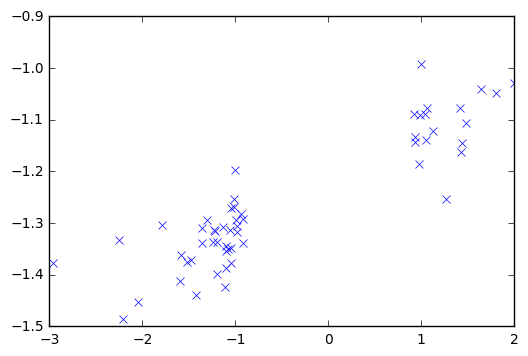

In [ ]:
# leave one out retraining 
subset = rank[30:100]
saver.restore(sess, checkpoint_file)
base_testset_loss = testset_loss()
for _,i in subset:
    z = (mnist.train.images[i:i+1], mnist.train.labels[i:i+1])
    z_influ, z_grad = inf.of_and_g(z)
    grads_l.append(z_grad*scale)
    new_mnist = Dataset(mnist_i2(i))
    train(10000, new_mnist, learning_rate=1e-7)
    d_loss = base_testset_loss - testset_loss()
    print(i, ":  ", z_influ * scale, d_loss)
    influence_acc.append( (z_influ * scale, d_loss) )
    infs.append(z_influ * scale )
    d_losses.append(d_loss)
    saver.restore(sess, checkpoint_file)
    clear_output()
    plt.plot(infs, d_losses, "x")
    plt.show()

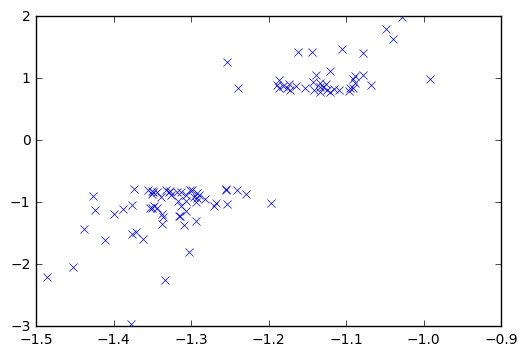

In [37]:
plt.plot(d_losses, infs, "x")

influence d_loss


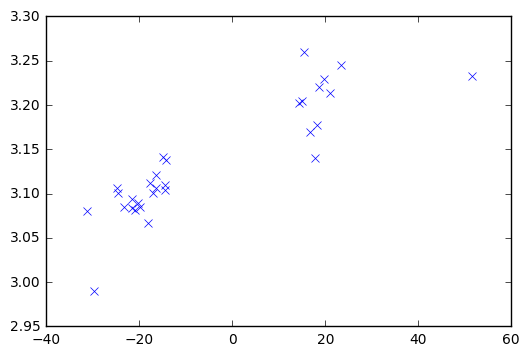

In [23]:
plt.plot(infs, d_losses, "x")

influence d_loss


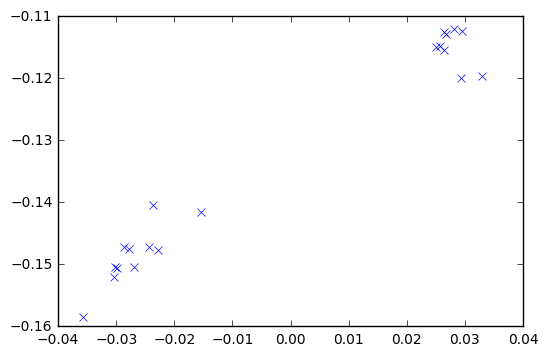

In [12]:
infs = []
d_losses = []
print("influence", "d_loss")
for pair in influence_acc:
    infs.append(pair[0])
    d_losses.append(pair[1])
    #print(pair[0], pair[1])
    
plt.plot(infs, d_losses, "x")

In [ ]:
plt.hist(trainset_influence, 1000, normed=True)
plt.xlim(-0.1, 0.1)

In [ ]:
influences_corrupted = []
influences_non_corrupted = []
grads_corrupted = []
grads_non_corrupted = []
#size = len(mnist.train.labels)
size = 1000
for i in range(size):
    z = (mnist.train.images[i:i+1], mnist.train.labels[i:i+1])
    influ, z_grad = inf.of_and_g(z)
    if mnist.train.corrupted_mask[i]:
        influences_corrupted.append(influ)
        grads_corrupted.append(z_grad)
    else:
        influences_non_corrupted.append(influ)
        grads_non_corrupted.append(z_grad)
all_influences = influences_corrupted + influences_non_corrupted
all_grads = grads_corrupted + grads_non_corrupted

In [83]:
print("non corrupted")
print("mean",np.mean( influences_non_corrupted))
print("std",np.std( influences_non_corrupted))

non corrupted
mean -6.47728385977e-08
std 1.21111189844e-05


In [84]:
print("corrupted")
print("mean",np.mean( influences_corrupted))
print("std",np.std( influences_corrupted))

corrupted
mean -1.88751401152e-06
std 5.31467498935e-06


In [16]:
inf.s = influence.lset(inf.s, 1.)

In [79]:
1

1

In [80]:
infs = []
d_losses = []
print("influence", "d_loss")
for pair in influence_acc:
    infs.append(pair[0])
    d_losses.append(pair[1])
    print(pair[0], pair[1])
    
plt.plot(infs, d_losses, "x")

influence d_loss
-3.42001894873 -12.5903
-3.42991299808 -12.5177
-3.31551817139 -12.4698
-3.1845451764 -12.823
-2.89722035186 -12.8751


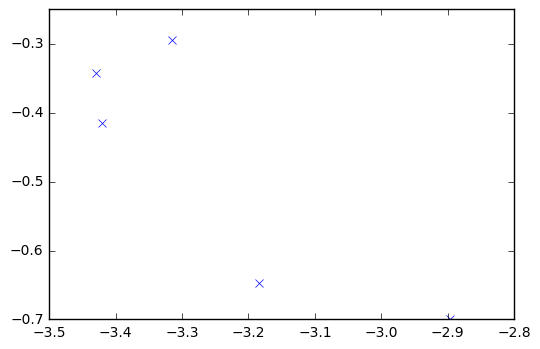

In [81]:
plt.plot(infs, d_losses - avrg, "x")

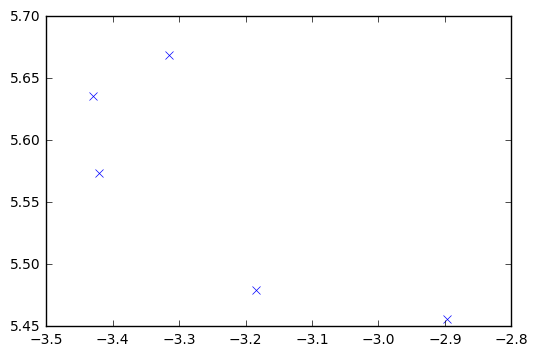

In [70]:
plt.plot(infs, d_losses - avrg, "x")

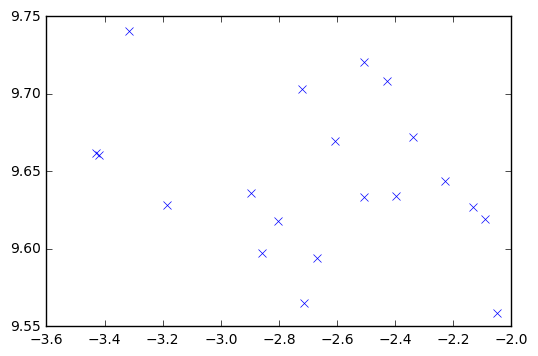

In [63]:
plt.plot(infs, d_losses - avrg, "x")

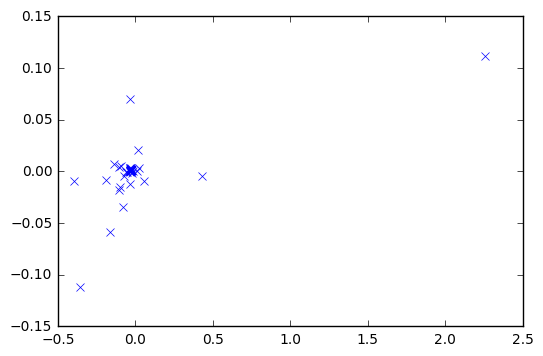

In [43]:
plt.plot(infs, d_losses - avrg, "x")

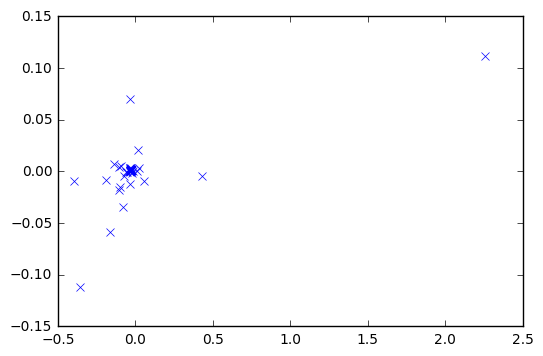

In [43]:
plt.plot(infs, d_losses - avrg, "x")

In [39]:
influence_acc
cu = 0
for i in range(len(influence_acc)):
    print(influence_acc[i], mnist.train.corrupted_mask[i])
    cu += influence_acc[i][1]

(-0.027689653809073733, -12.173828) False
(2.253888293622941, -12.064087) False
(-0.057892054706257245, -12.17627) True
(-0.028630717219882418, -12.174316) False
(-0.015116766469772114, -12.174805) False
(0.017373136347864637, -12.154297) False
(-0.027889592524935058, -12.174683) False
(-0.028365732707147373, -12.173828) False
(-0.028661911857935651, -12.174316) False
(-0.032132640476745244, -12.174683) False
(0.42866204244207395, -12.179932) False
(-0.029064536376452454, -12.174072) False
(-0.16695554828166648, -12.234497) False
(-0.094426384465995383, -12.169678) False
(-0.099014407147698935, -12.190796) True
(0.053566588407716331, -12.184204) False
(-0.053189263293645928, -12.175903) False
(-0.028707009974843212, -12.174072) False
(-0.02871165062694192, -12.174072) False
(-0.029057295559478669, -12.173828) False
(-0.028698393551712664, -12.174194) False
(0.0093212496818373403, -12.175415) False
(-0.031820806585119987, -12.175049) False
(-0.031968775614441003, -12.173096) False
(-0.1

In [76]:
inf72 = np.load("influence-d_loss")

FileNotFoundError: [Errno 2] No such file or directory: 'influence-d_loss'

In [47]:
np.save("influence-d_loss", influence_acc)

In [77]:
influence_acc

[(-3.4200348640034406, -12.590576),
 (-3.4298843697477821, -12.517456),
 (-3.3155329146516976, -12.46936),
 (-3.1844899987731878, -12.822754),
 (-2.8972173116414979, -12.875244)]

In [42]:
avrg = cu/len(influence_acc)

In [35]:
saver.restore(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")
base_testset_loss = testset_loss()
train(10000, mnist.train, learning_rate=1e-7)
d_loss = base_testset_loss - testset_loss()
print(d_loss)

-4.37305


In [37]:
1

1

In [86]:
saver.restore(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")

In [87]:
sess.run(tf.global_variables_initializer())

In [10]:
test()
for i in range(10):
    train(10000, mnist.train)
    test()
print("XXXX")
for i in range(10):
    train(10000, mnist.train, 1e-5)
    test() 
print("XXXX")
for i in range(10):
    train(10000, mnist.train, 1e-6)
    test()
print("XXXX")
for i in range(10):
    train(10000, mnist.train, 1e-7)
    test()

test acc 0.0846
test loss 30870.3
train acc 0.0891
train loss 31078.4
---
test acc 0.9632
test loss 1621.01
train acc 0.9499
train loss 2671.71
---
test acc 0.9712
test loss 1323.3
train acc 0.9639
train loss 1933.37
---
test acc 0.9732
test loss 1229.11
train acc 0.9698
train loss 1451.83
---
test acc 0.9725
test loss 1166.37
train acc 0.9756
train loss 1049.5
---
test acc 0.9734
test loss 1083.27
train acc 0.9822
train loss 731.857
---
test acc 0.9726
test loss 1060.42
train acc 0.9905
train loss 486.994
---
test acc 0.9716
test loss 1048.83
train acc 0.9961
train loss 306.672
---
test acc 0.9711
test loss 1017.23
train acc 0.9983
train loss 184.784
---
test acc 0.9701
test loss 1028.05
train acc 0.9988
train loss 113.906
---
test acc 0.9704
test loss 1045.9
train acc 0.9994
train loss 69.462
---
XXXX
test acc 0.9698
test loss 1084.29
train acc 0.9999
train loss 42.4314
---
test acc 0.9689
test loss 1126.6
train acc 0.9999
train loss 32.3282
---
test acc 0.9689
test loss 1157.06
trai

In [18]:
saver.save(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")

'/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt'